In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

True

**Table of contents**<a id='toc0_'></a>    
- [Summary](#toc1_)    
- [Сколько всего слайдов](#toc2_)    
- [Разрешения](#toc3_)    
  - [Разрешения не всегда инты](#toc3_1_)    
  - [Стандарт 16/9. Цена типичного слайда](#toc3_2_)    
  - [Какие разрешения в разных датасетах](#toc3_3_)    
- [Сколько платить за разметку](#toc4_)    
- [Про расчет цен и токенов](#toc5_)    
  - [Примеры с vsegpt.ru](#toc5_1_)    
  - [Как считать токены для картинок. Про х33 для gpt-4o-mini](#toc5_2_)    
  - [Цены на токены. Vsegpt скамит на vision](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Summary](#toc0_)
Выводы:
- В презентациях по data-science 3600 слайдов
- С OpenAI разметка будет стоить ~17\$
- Vision стоит одинаково для `gpt-4o` и `gpt-4o-mini`
- Vision на `vsegpt.ru` в 2.5 раза дороже, чем для `openai`

## Метрики данных
- Распределение количества слайдов в презентациях
- Разрешения документов
- Цены на токены - не является метрикой, но тоже часть проекта

# <a id='toc2_'></a>[Сколько всего слайдов](#toc0_)

In [2]:
from src import Config
from src.eda import parse_pdf_directory

config = Config()

df = parse_pdf_directory(config.navigator.raw, exclude_datasets=["weird-slides"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       77 non-null     object 
 1   relative_path  77 non-null     object 
 2   topic          77 non-null     object 
 3   dataset        77 non-null     object 
 4   nav            77 non-null     object 
 5   num_pages      77 non-null     int64  
 6   title          77 non-null     object 
 7   author         77 non-null     object 
 8   subject        77 non-null     object 
 9   keywords       77 non-null     object 
 10  page_width     77 non-null     float64
 11  page_height    77 non-null     float64
 12  varying_sizes  77 non-null     object 
dtypes: float64(2), int64(1), object(10)
memory usage: 7.9+ KB


In [3]:
pages_count = (
    df
    .groupby("topic")
    .aggregate(
        total_presentations=("num_pages", "count"),
        total_slides=("num_pages", "sum"),
    )
    .reset_index()
)
pages_count

,topic,total_presentations,total_slides
0,business,8,220
1,data-science,69,3604


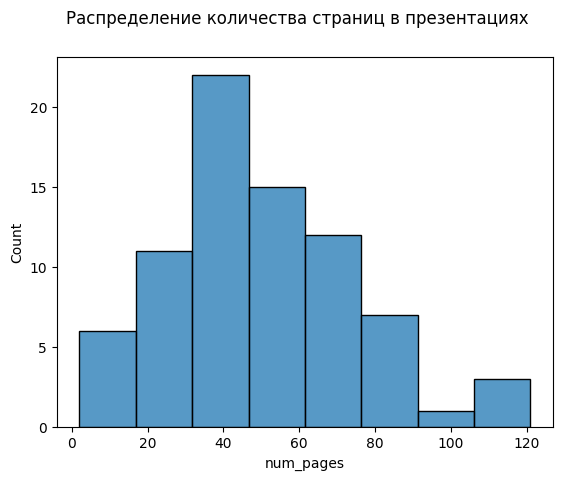

In [9]:
import seaborn as sns

g = sns.histplot(df, x='num_pages')
g = g.figure.suptitle("Распределение количества страниц в презентациях")

# <a id='toc3_'></a>[Разрешения](#toc0_)

Разрешение - пара (width, height) - количество пикселей, которые приходятся на ширину/высоту.

Есть несколько причин смотреть на разрешение документов при работе с презентациями: 
1. Фильтр "не презентаций". У презентаций ширина больше высоты. Если наоборот, то это скорее книга/документ. Могут быть вертикальные презентации, но редко.
2. Размер файла на диске. Больше пикселей - больше размер. \
   Для моих задач не нужны ultra-high-res презентации - достаточно стандартных 960х540. Презентации с высоким разрешением можно сжать.

## <a id='toc3_1_'></a>[Разрешения не всегда инты](#toc0_)

In [62]:
resolutions = (
    df.assign(
        resolution=lambda df_: list(df_[['page_width', 'page_height']].itertuples(index=False, name=None))
    )
    .groupby("resolution")
    .aggregate(
        count=("resolution", "count")
    )
    .sort_values("count", ascending=False)
    .reset_index()
)
resolutions

,resolution,count
0,"(960.0, 540.0)",41
1,"(720.0, 405.0)",10
2,"(1920.0, 1080.0)",7
3,"(1919.8800048828125, 1080.0)",4
4,"(1440.0, 810.0)",3
5,"(1559.0400390625, 878.760009765625)",3
6,"(1919.0, 1080.0)",2
7,"(453.5429992675781, 255.1179962158203)",1
8,"(595.3200073242188, 841.9199829101562)",1
9,"(780.0, 540.0)",1


Не все они инты.

## <a id='toc3_2_'></a>[Стандарт 16/9. Цена типичного слайда](#toc0_)
Я округлил разрешения до 10 и посчитал aspect. Результаты и выводы ниже

In [63]:
from fractions import Fraction
from src.eda import calculate_image_tokens, tokens2price

openai_1k_token_price = 0.00015 # https://openai.com/api/pricing/
prompt_tokens = 3500

df_int_res = (
    df.assign(
        # Round resolutions to 10
        resolution=lambda df_: (
            list(df_[['page_width', 'page_height']]
            .astype(int).round(-1)
            .itertuples(index=False, name=None))
        ),

        # Calculate aspect
        aspect=lambda df_: (
            df_["resolution"]
            .apply(lambda x: Fraction(x[0], x[1]) )
        ),

        # Vision tokens
        page_vision_tokens=lambda df_: (
            df_["resolution"]
            .apply(lambda x: calculate_image_tokens(*x))
        ),

        # Vision tokens for mini are x33
        page_vision_tokens_mini=lambda df_: df_["page_vision_tokens"] * 33,

        # Add system tokens
        page_total_tokens = lambda df_: (
            df_["page_vision_tokens_mini"] + prompt_tokens
        ),

        # Page cost
        page_cost=lambda df_: (
            df_["page_total_tokens"]
            .apply(lambda x: tokens2price(x, openai_1k_token_price))
        ),

        # Total tokens per presentation
        pres_total_tokens = lambda df_: df_["page_total_tokens"] * df_["num_pages"],

        # Tokens for openai
        pres_total_cost=lambda df_: (
            df_["page_cost"] * df_["num_pages"]
        )
    )
)

resolutions = (
    df_int_res
    .groupby(["resolution", "aspect"])
    .aggregate(
        pres_count=("resolution", "count"),
        page_tokens=("page_vision_tokens", "first"),
    )
    .sort_values("pres_count", ascending=False)
    .reset_index()
)
resolutions

,resolution,aspect,pres_count,page_tokens
0,"(960, 540)",16/9,42,765
1,"(1920, 1080)",16/9,14,1105
2,"(720, 400)",9/5,10,425
3,"(1560, 880)",39/22,4,1105
4,"(1440, 810)",16/9,3,1105
5,"(450, 260)",45/26,1,255
6,"(600, 840)",5/7,1,765
7,"(780, 540)",13/9,1,765
8,"(1220, 790)",122/79,1,1105


- Преобладает дефолтое разрешение PowerPoint: 960x540 (16/9)
- Есть 1920x1080. В принципе, их можно уменьшать в два раза, чтобы сэкономить на токенах.

Посмотрим, сколько они будут стоить:

In [64]:
resolutions_costs = (
    df_int_res
    .groupby(["resolution", "aspect"])
    .aggregate(
        pres_count=("resolution", "count"),
        page_cost=("page_cost", lambda df_: df_.iloc[0].round(4)),
        pages_count=("num_pages", "sum"),
        total_cost=("pres_total_cost", lambda df_: df_.sum().round(2)),
    )
    .sort_values("pres_count", ascending=False)
    .reset_index()
)
resolutions_costs

,resolution,aspect,pres_count,page_cost,pages_count,total_cost
0,"(960, 540)",16/9,42,0.0043,2179,9.40
1,"(1920, 1080)",16/9,14,0.0060,701,4.20
2,"(720, 400)",9/5,10,0.0026,429,1.13
3,"(1560, 880)",39/22,4,0.0060,257,1.54
4,"(1440, 810)",16/9,3,0.0060,111,0.67
5,"(450, 260)",45/26,1,0.0018,86,0.15
6,"(600, 840)",5/7,1,0.0043,2,0.01
7,"(780, 540)",13/9,1,0.0043,20,0.09
8,"(1220, 790)",122/79,1,0.0060,39,0.23


## <a id='toc3_3_'></a>[Какие разрешения в разных датасетах](#toc0_)
Та же таблица, но с датасетами

In [65]:
resolutions = (
    df_int_res
    .apply(lambda x: x)
    .groupby(["resolution", "aspect", "dataset"])
    .aggregate(
        count=("resolution", "count")
    )
    .sort_values("count", ascending=False)
    .reset_index()
)
resolutions

,resolution,aspect,dataset,count
0,"(960, 540)",16/9,aiconf,31
1,"(1920, 1080)",16/9,aiconf,9
2,"(720, 400)",9/5,aiconf,6
3,"(960, 540)",16/9,yappi-days,6
4,"(1920, 1080)",16/9,yappi-days,5
5,"(720, 400)",9/5,yappi-days,4
6,"(960, 540)",16/9,insider_infor,4
7,"(1440, 810)",16/9,yappi-days,3
8,"(1560, 880)",39/22,aiconf,3
9,"(450, 260)",45/26,aiconf,1


# <a id='toc4_'></a>[Сколько платить за разметку](#toc0_)

In [58]:
price = (
    df_int_res
    .groupby("topic")
    .aggregate(
        total_presentations=("title", "count"),
        total_slides=("num_pages", "sum"),
        total_tokens=("pres_total_tokens", "sum"),
        total_cost_usd=("pres_total_cost", "sum")
    )
    .reset_index()
    .assign(
        total_tokens=lambda df_: (
            df_["total_tokens"]
            .apply(lambda x: f"{x:.2e}" )
        ),
        total_cost_usd=lambda df_: (
            df_["total_cost_usd"]
            .round(2)
        )
    )
    .sort_values("total_cost_usd", ascending=False)
)
price

,topic,total_presentations,total_slides,total_tokens,total_cost_usd
1,data-science,69,3604,1.09e+08,16.40
0,business,8,220,6.76e+06,1.01


# <a id='toc5_'></a>[Про расчет цен и токенов](#toc0_)
## <a id='toc5_1_'></a>[Примеры с vsegpt.ru](#toc0_)

Я использую gpt-4o-mini. Идея: стоит в 33 раза дешевле, а перформит примерно также.

Процессинг картинок у gpt-4o-mini и gpt-4o стоит одинаково. Поэтому для мини картинки занимают в 33 раза больше токенов - костыль от OpenAI. 

Посмотрим на примере:

In [64]:
from langchain_community.callbacks.manager import get_openai_callback
from src import (SingleSlidePipeline, Config, display_chain_outputs)
from src.config.output_formatting import format_dict_output
from src.chains.prompts import JsonH1AndGDPrompt
from src.chains.chains import FindPdfChain

config = Config()

models = ["vis-openai/gpt-4o", "vis-openai/gpt-4o-mini"]
llms = [config.model_config.load_vsegpt(model=model) for model in models]

slide_pipelines = [
    (
        FindPdfChain()
        | SingleSlidePipeline(
            llm=llm,
            vision_prompt=JsonH1AndGDPrompt(),
            return_steps=True)
    )
    for llm in llms
]

In [ ]:
pres_title = "7. Коченюк"
outs = []
for model, slide_pipeline in zip(models, slide_pipelines):
    with get_openai_callback() as cb:
        out = slide_pipeline.invoke(
            dict(
                pdf_path=pres_title,
                page_num=1
            )
        )
        outs.append(out)
    print(f"LLM: {model}")
    print(cb)
    print("\n---")

LLM: vis-openai/gpt-4o
Tokens Used: 4713
	Prompt Tokens: 4380
	Completion Tokens: 333
Successful Requests: 1
Total Cost (USD): $0.0

---
LLM: vis-openai/gpt-4o-mini
Tokens Used: 29446
	Prompt Tokens: 29116
	Completion Tokens: 330
Successful Requests: 1
Total Cost (USD): $0.0

---


Не смотрим на TotalCost - это баг от vsegpt.ru. Вот что написано в личном кабинете:

- Это для 960x540 слайда:

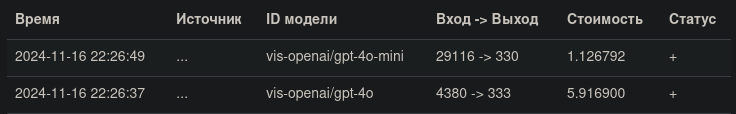

In [29]:
pres_title = "3.Разметка будущего как GPT помогает обучать модели_Герман Ганус_вер.4"
outs = []
for model, slide_pipeline in zip(models, slide_pipelines):
    with get_openai_callback() as cb:
        out = slide_pipeline.invoke(
            dict(
                pdf_path=pres_title,
                page_num=1
            )
        )
        outs.append(out)
    print(f"LLM: {model}")
    print(cb)
    print("\n---")

LLM: vis-openai/gpt-4o
Tokens Used: 5153
	Prompt Tokens: 4720
	Completion Tokens: 433
Successful Requests: 1
Total Cost (USD): $0.0

---
LLM: vis-openai/gpt-4o-mini
Tokens Used: 40822
	Prompt Tokens: 40450
	Completion Tokens: 372
Successful Requests: 1
Total Cost (USD): $0.0

---


- Это для 1920x1080 слайда:

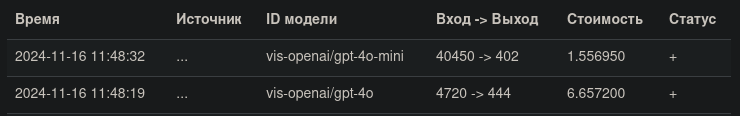


Сравним вывод моделей:

Model: vis-openai/gpt-4o
--------


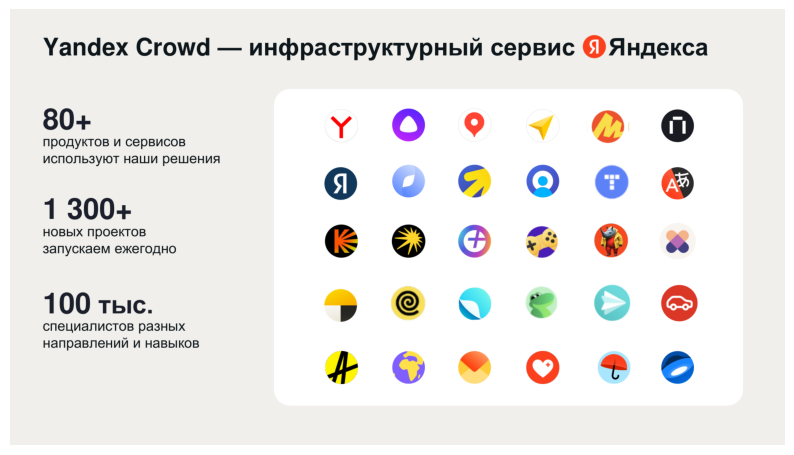

Structured Analysis:
Text Content:
    Заголовок: "Yandex Crowd — инфраструктурный сервис Яндекса"
    
    Текстовые блоки:
    1. "80+ продуктов и сервисов используют наши решения"
    2. "1 300+ новых проектов запускаем ежегодно"
    3. "100 тыс. специалистов разных направлений и навыков"
    
    Стилизация текста: 
    - Числовые значения выделены жирным шрифтом для акцента
    - Используется крупный шрифт для заголовка
Visual Content:
    На правой стороне слайда расположены иконки различных сервисов и 
    продуктов Яндекса, организованные в сетку из 5 рядов и 6 колонок. 
    Иконки представляют собой логотипы, каждый из которых имеет уникальный
     дизайн и цветовую схему.
    
    Цветовая палитра иконок разнообразна, что подчеркивает разнообразие 
    сервисов. Иконки расположены на белом фоне, что обеспечивает хороший 
    контраст и видимость.
    
    Отсутствие дополнительных декоративных элементов позволяет 
    сосредоточиться на ключевой информации и визуальных элемен

In [ ]:
print(f"Model: {models[0]}\n--------")
display_chain_outputs(outs[0]["chain_outputs"])

print(f"\n\nModel: {models[0]}\n--------")
display_chain_outputs(outs[1]["chain_outputs"], display_image=False)

## <a id='toc5_2_'></a>[Как считать токены для картинок. Про х33 для gpt-4o-mini](#toc0_)
- Для расчета нужно только разрешение картинки - [гайд от openai](https://platform.openai.com/docs/guides/vision#calculating-costs). 
  - Рескейлим, чтобы меньшая сторона была 768px
  - Считаем покрытие квадратами 512x512. Каждый квадрат - 170 токенов. 
  - Добавляем 85 токенов - видимо, за отправку.
- Для мини токены для vision умножаются на 33 - [ссылка на форум](https://community.openai.com/t/gpt-4o-mini-high-vision-cost/872382)
  - vision для всех моделей стоит одинаково
  - токены для мини стоят в 33 раза меньше
  - для мини vision токены умножаются на 33, чтобы сбалансировать цену 

*Функцию скопипастил с форума, но проверил - [ссылка](https://community.openai.com/t/how-do-i-calculate-image-tokens-in-gpt4-vision/492318/6)*

In [107]:
from IPython.display import display, Code
import inspect

Code(inspect.getsource(calculate_image_tokens))

def calculate_image_tokens(width: int, height: int):
    if width > 2048 or height > 2048:
        aspect_ratio = width / height
        if aspect_ratio > 1:
            width, height = 2048, int(2048 / aspect_ratio)
        else:
            width, height = int(2048 * aspect_ratio), 2048

    if width >= height and height > 768:
        width, height = int((768 / height) * width), 768
    elif height > width and width > 768:
        width, height = 768, int((768 / width) * height)

    tiles_width = ceil(width / 512)
    tiles_height = ceil(height / 512)
    total_tokens = 85 + 170 * (tiles_width * tiles_height)

    return total_tokens

In [ ]:
resolution = (960, 540)
n_tokens = calculate_image_tokens(*resolution)
print(f"Resolution: {resolution}")
print(f"Vision tokens GPT-4o: {n_tokens}")
print(f"Vision tokens for mini: {n_tokens * 33}")

Resolution: (960, 540)
Vision tokens GPT-4o: 765
Vision tokens for mini: 25245


In [9]:
resolution = (1920, 1080)
n_tokens = calculate_image_tokens(*resolution)
print(f"Resolution: {resolution}")
print(f"Vision tokens GPT-4o: {n_tokens}")
print(f"Vision tokens for mini: {n_tokens * 33}")

Resolution: (1920, 1080)
Vision tokens GPT-4o: 1105
Vision tokens for mini: 36465


`vision_prompt` занимает примерно 3700 токенов - смотрел в [openai-tokenizer](https://platform.openai.com/tokenizer)

## <a id='toc5_3_'></a>[Цены на токены. Vsegpt скамит на vision](#toc0_)

| provider | model              | $ per 1000 tokens |
| -------- | -------------      | ----------------- |
| openai   | gpt-4o-mini        | 0.00015           |
| vsegpt   | gpt-4o-mini        | 0.0002            |
| vsegpt   | gpt-4o-mini-vision | 0.00037           |

*1$ = 100руб*

Ссылки:
- [Цены vsegpt.ru](https://vsegpt.ru/Docs/Models)
- [Цены openai](https://openai.com/api/pricing/)
 
vsegpt берут за vision дороже. У opeanai платим за токены - vision/text без разницы.

Для текста их сервис использовать можно. Для vision x2.5 в цене - такое